In [1]:
!nvidia-smi

Fri Nov 17 19:12:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# <font color = 'pickle'>**Handling Long Sequence- Chunking** </font>

# <font color = 'pickle'>**Binary Classification - Sentiment Analysis with the IMDB Dataset** </font>






# <font color = 'pickle'> **Setting up the Environment** </font>

In [2]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/BUAN 6342.501 - Applied Natural Language Processing (Harpreet Singh)/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'Lectures/0_Data_Folder'
model_folder = base_folder/'Assignments/HW7/models'
model_folder.mkdir(exist_ok=True)

In [4]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

import textwrap

# <font color = 'pickle'> **Exploring and Understanding Dataset**

## <font color = 'pickle'> **Load Data set**
    


In [5]:
from datasets import load_dataset, DatasetDict

In [6]:
stack_dataset = load_dataset('csv', data_files= str(data_folder /'multiclass_hw_basic_clean.csv'))

## <font color = 'pickle'> **Understanding your data**

In [7]:
print(stack_dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'Title', 'Body', 'cleaned_text', 'Tags', 'Tag_Number_final', 'combined_text', 'basic_cleaned_text'],
        num_rows: 188878
    })
})


## <font color = 'pickle'> **Understanding the datatype of columns**


In [8]:
stack_dataset['train'].features

{'Unnamed: 0.1': Value(dtype='int64', id=None),
 'Unnamed: 0': Value(dtype='int64', id=None),
 'Title': Value(dtype='string', id=None),
 'Body': Value(dtype='string', id=None),
 'cleaned_text': Value(dtype='string', id=None),
 'Tags': Value(dtype='string', id=None),
 'Tag_Number_final': Value(dtype='int64', id=None),
 'combined_text': Value(dtype='string', id=None),
 'basic_cleaned_text': Value(dtype='string', id=None)}

## <font color = 'pickle'> **Acess indivdual element** </font>
 The dataset behaves like an Python array or list. We can use the familiar indexing/slicing methods to access individual elements.

In [9]:
# Assuming 'stack_dataset' is a huggingface dataset
# Select only the desired columns and rename them
selected_columns = {
    'text': stack_dataset['train']['basic_cleaned_text'],
    'label': stack_dataset['train']['Tag_Number_final']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)


In [10]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [11]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

## <font color = 'pickle'> **Exploratory Data Analysis (EDA)**

### <font color = 'pickle'> **Change dataset format to Pandas**  </font>
We will convert the datasets to Pandas DataFrames for visualization and Exploratory Data Analysis (EDA) because Pandas provides a wide range of tools and functions that simplify data manipulation, aggregation, and visualization, making it an ideal choice for these tasks

In [12]:
# Set the format to Pandas
stack_selected_columns.set_format(type = 'pandas')

In [13]:
# get all rows the dataset
df = stack_selected_columns[:]

In [14]:
df.head()


,text,label
0,detail disclosure indicator on UIButton Is the...,8
1,hello world fails to show up in emulator I fol...,4
2,"Why is JSHint throwing a ""possible strict viol...",3
3,Programmatically Make Bound Column Invisible I...,9
4,"More than one EditText - not getting focus, no...",4


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188878 entries, 0 to 188877
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    188874 non-null  object
 1   label   188878 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


### <font color = 'pickle'> **Visualize distribution of class labels** </font>
It is important to undetrstand the distribution of the class labels to check if there is any imbalance among the categories.

<Axes: >

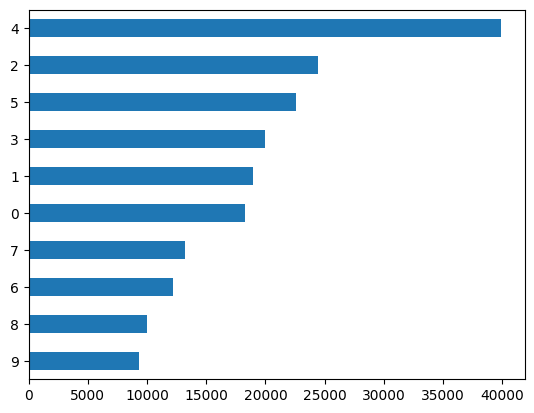

In [16]:
# Plot a horizontal bar chart showing the count of each unique value in the 'label' column of the dataframe 'df'.
# The counts are displayed in ascending order for better visualization of the distribution.
# CODE HERE
df['label'].value_counts(ascending=True).plot.barh()


In [17]:
# 1. Compute the class frequencies:
class_weights = df['label'].value_counts(normalize=True, sort=False)

# 2. Sort weights by index (i.e., by label):
class_weights = class_weights.sort_index()

# 3. Compute the inverse of the class frequencies:
class_weights = 1/class_weights

# 4. Normalize the weights so they sum up to 1 (this step is optional but can be useful):
class_weights = class_weights / class_weights.sum()

# 5. Convert the weights to a PyTorch tensor:
class_tensor_weights = torch.tensor(class_weights.values, dtype=torch.float)

In [18]:
class_tensor_weights

tensor([0.0864, 0.0834, 0.0646, 0.0791, 0.0396, 0.0701, 0.1296, 0.1194, 0.1576,
        0.1700])

### <font color = 'pickle'> **Check length of the reviews** </font>


In [19]:
# Add empty strings for rows atht do not have any text
df['text'] = df['text'].fillna('')
# Add a new column to the dataframe 'df' named 'words_per_review'.
# This column computes the number of words in each review in the 'text' column by splitting the text on spaces and counting the resulting words.
df['words_per_review'] = df['text'].str.split().apply(len)

In [20]:
df.head()

,text,label,words_per_review
0,detail disclosure indicator on UIButton Is the...,8,80
1,hello world fails to show up in emulator I fol...,4,256
2,"Why is JSHint throwing a ""possible strict viol...",3,40
3,Programmatically Make Bound Column Invisible I...,9,60
4,"More than one EditText - not getting focus, no...",4,197


#### <font color = 'pickle'> **Plot the distribution of review length** </font>

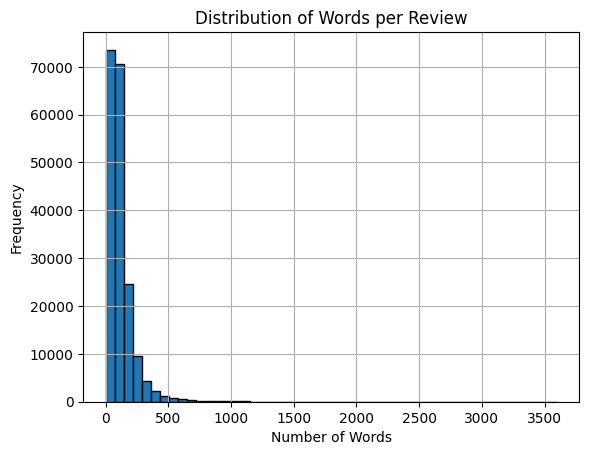

In [21]:
# Plot a histogram of the 'words_per_review' column
df['words_per_review'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


In [22]:
# The model we are going to use has token (subwords) limit of 512.
# Let us check how many reviews has more than 500 words

count = (df['words_per_review'] > 400).sum()
print(f"Number of reviews with more than 400 words: {count}")


Number of reviews with more than 400 words: 4772


### <font color = 'pickle'> **Reset dataset format** </font>


In [23]:
stack_selected_columns = stack_selected_columns.from_pandas(df).remove_columns('words_per_review')
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [24]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

# <font color = 'pickle'> **Data Pre-processing**</font>

## <font color = 'pickle'> **Filtering Larger Reviews**</font>

In [25]:
def filter_long_samples(example):
    return len(example['text'].split()) > 400

stack_selected_columns_long = stack_selected_columns.filter(filter_long_samples)


Filter:   0%|          | 0/188878 [00:00<?, ? examples/s]

In [26]:
stack_selected_columns_long

Dataset({
    features: ['text', 'label'],
    num_rows: 4772
})

In [27]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']
stack_selected_columns_long = stack_selected_columns_long.cast_column('label', ClassLabel(names=class_names))

Casting the dataset:   0%|          | 0/4772 [00:00<?, ? examples/s]

### <font color = 'pickle'> **Create futher subdivions of the splits** </font>

In [28]:
# Split the test set into test and validation sets
# train_temp_split = stack_selected_columns_long.train_test_split(train_size = 0.6,test_size=0.4, seed=42,stratify_by_column='label')
# test_val_splits = train_temp_split["test"].train_test_split(test_size=0.4, seed=42,stratify_by_column='label')
train_temp_split = stack_selected_columns_long.train_test_split(train_size = 0.6,test_size=0.4, seed=42)
test_val_splits = train_temp_split["test"].train_test_split(test_size=0.4, seed=42)

# Extract the train,test and val split
train_split = train_temp_split["train"]
valid_split = test_val_splits["train"]
test_split = test_val_splits["test"]


In [29]:
train_split,valid_split, test_split

(Dataset({
     features: ['text', 'label'],
     num_rows: 2863
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1145
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 764
 }))

### <font color = 'pickle'> **Create subset for experimentation** </font>

In [30]:
train_split_small = train_split.shuffle(seed=42).select(range(10))
val_split_small = valid_split.shuffle(seed=42).select(range(10))
test_split_small = test_split.shuffle(seed=42).select(range(10))


### <font color = 'pickle'> **Combine splits**</font>



In [31]:
train_val = DatasetDict(
    {"train": train_split, "valid": valid_split})
train_val_small = DatasetDict(
    {"train": train_split_small, "valid": val_split_small})


In [32]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2863
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1145
    })
})

In [33]:
train_val_small

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
})

In [34]:
train_val.set_format(type='pandas')

In [35]:
df_train = train_val['train'][:]

<Axes: >

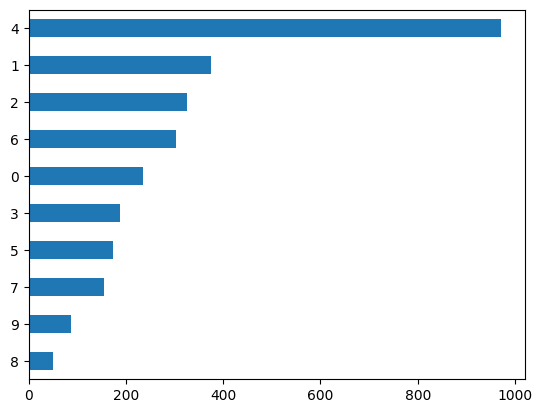

In [36]:
# check ditsribution of class labels in training dataset
df_train['label'].value_counts(ascending=True).plot.barh()

In [37]:
# check distribution of text length
df_train['words_per_review'] = df_train['text'].str.split().apply(len)

<Axes: >

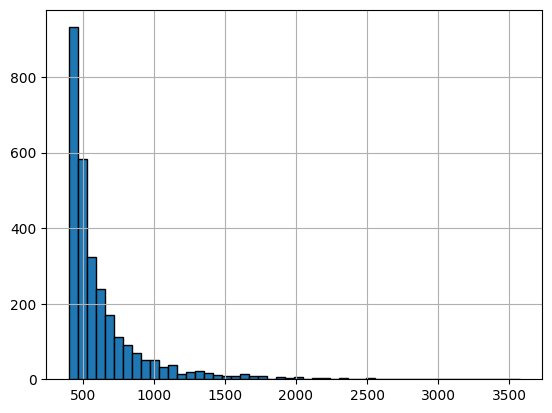

In [38]:
# Plot a histogram of the 'words_per_review' column
df_train['words_per_review'].hist(bins=50, edgecolor='black')

In [39]:
count = (df_train['words_per_review'] > 400).sum()
print(f"Number of reviews with more than 400 words: {count}")

Number of reviews with more than 400 words: 2863


In [40]:
count = (df_train['words_per_review'] < 400).sum()
print(f"Number of reviews with more than 400 words: {count}")

Number of reviews with more than 400 words: 0


In [41]:
train_val.reset_format()

## <font color = 'pickle'> **Tokenization**</font>

###  <font color = 'pickle'> **Load pre-trained Tokenizer** </font>

In [42]:
from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


###  <font color = 'pickle'> **Understanding pre-trained Tokenizer**
We will now understand how the tokenizer work by feeding one simple example.

In [43]:
text = ["Tokenization is the process of splitting sequence to tokens",
        "I like BUAN6482"]

In [44]:
# get the vocab size
print(f'Pretrained tokenizer vocab size {tokenizer.vocab_size}')

Pretrained tokenizer vocab size 30522


- <font color = 'indianblue'>The vocab size for the tokenizer for bert-base-uncased model is 30522.

In [45]:
encoded_text = tokenizer(
    text, padding=True, truncation=False, return_tensors='pt')

In [46]:
encoded_text


{'input_ids': tensor([[  101, 19204,  3989,  2003,  1996,  2832,  1997, 14541,  5537,  2000,
         19204,  2015,   102],
        [  101,  1045,  2066, 20934,  2319, 21084,  2620,  2475,   102,     0,
             0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}

In [47]:
tokens_first_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[0])
tokens_second_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[1])

print(tokens_first_sentence)
print(tokens_second_sentence)


['[CLS]', 'token', '##ization', 'is', 'the', 'process', 'of', 'splitting', 'sequence', 'to', 'token', '##s', '[SEP]']
['[CLS]', 'i', 'like', 'bu', '##an', '##64', '##8', '##2', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [48]:
tokenizer.convert_tokens_to_string(tokens_first_sentence)

'[CLS] tokenization is the process of splitting sequence to tokens [SEP]'

In [49]:
tokenizer.convert_tokens_to_string(tokens_second_sentence)

'[CLS] i like buan6482 [SEP] [PAD] [PAD] [PAD] [PAD]'

In [50]:
special_tokens = tokenizer.all_special_tokens
special_tokens_ids = tokenizer.all_special_ids
print(special_tokens, special_tokens_ids)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] [100, 102, 0, 101, 103]


##  <font color = 'pickle'> **Create Custom_Collate function**

In [51]:
train_val['train']['text'][0]

'Fatal error: Call to a member function AddUser() on a non-object so after hours on the web searching for smallest details or solution for this error I still can\'t fix it The errors : Notice: Undefined variable: Login in C:\\xampp\\htdocs\\up\\administration\\adduser.php on line 3  Fatal error: Call to a member function AddUser() on a non-object in C:\\xampp\\htdocs\\up\\administration\\adduser.php on line 3  These errors are from adduser.php which contains <?php require_once(\'LoginClass.php\'); $Login->AddUser(\'Test\',\'test312\'); ?>  And this is the LoginClass.php <?php  class Login {  //Username Variables private $username; private $password;  //MySQL Variables private $Host; private $MySQLUsername; private $MySQLPassword; private $Database; private $Conn;   //Constructor public function Login() {     session_start();     $this->Host = "localhost";     $this->MySQLUsername = "root";     $this->MySQLPassword = "";     $this->Database = "up";      $this->Connection();      unset($

In [52]:
from datasets import Dataset

texts = [{"text": "Tokenization is the process of splitting sequence to tokens. It's one of the fundamental tasks in natural language processing. However, there are various methods to achieve tokenization in different scenarios.", "label": 1},
         {"text": "I like BUAN6482", "label": 0},
         {"text": "Neural networks using attention mechanisms to process sequences, revolutionizing natural language processing tasks", "label": 0}]

# Convert list of dictionaries to dictionary of lists
data = {
    "text": [item["text"] for item in texts],
    "label": [item["label"] for item in texts]
}

dataset_dummy = Dataset.from_dict(data)

print(dataset_dummy)



Dataset({
    features: ['text', 'label'],
    num_rows: 3
})


In [53]:
dataset_dummy['text'][1]

'I like BUAN6482'

In [54]:
tokenized_outputs_dummy = tokenizer(dataset_dummy['text'],
                        padding='longest',
                        truncation=True,
                        return_tensors='pt',
                        max_length=10,
                        return_overflowing_tokens=True,
                        stride=3)

In [55]:
tokenized_outputs_dummy

{'input_ids': tensor([[  101, 19204,  3989,  2003,  1996,  2832,  1997, 14541,  5537,   102],
        [  101,  1997, 14541,  5537,  2000, 19204,  2015,  1012,  2009,   102],
        [  101,  2015,  1012,  2009,  1005,  1055,  2028,  1997,  1996,   102],
        [  101,  2028,  1997,  1996,  8050,  8518,  1999,  3019,  2653,   102],
        [  101,  1999,  3019,  2653,  6364,  1012,  2174,  1010,  2045,   102],
        [  101,  2174,  1010,  2045,  2024,  2536,  4725,  2000,  6162,   102],
        [  101,  4725,  2000,  6162, 19204,  3989,  1999,  2367, 16820,   102],
        [  101,  1999,  2367, 16820,  1012,   102,     0,     0,     0,     0],
        [  101,  1045,  2066, 20934,  2319, 21084,  2620,  2475,   102,     0],
        [  101, 15756,  6125,  2478,  3086, 10595,  2000,  2832, 10071,   102],
        [  101,  2000,  2832, 10071,  1010,  4329,  6026,  3019,  2653,   102],
        [  101,  6026,  3019,  2653,  6364,  8518,   102,     0,     0,     0]]), 'attention_mask': tensor

In [56]:
tokenized_outputs_dummy['input_ids']

tensor([[  101, 19204,  3989,  2003,  1996,  2832,  1997, 14541,  5537,   102],
        [  101,  1997, 14541,  5537,  2000, 19204,  2015,  1012,  2009,   102],
        [  101,  2015,  1012,  2009,  1005,  1055,  2028,  1997,  1996,   102],
        [  101,  2028,  1997,  1996,  8050,  8518,  1999,  3019,  2653,   102],
        [  101,  1999,  3019,  2653,  6364,  1012,  2174,  1010,  2045,   102],
        [  101,  2174,  1010,  2045,  2024,  2536,  4725,  2000,  6162,   102],
        [  101,  4725,  2000,  6162, 19204,  3989,  1999,  2367, 16820,   102],
        [  101,  1999,  2367, 16820,  1012,   102,     0,     0,     0,     0],
        [  101,  1045,  2066, 20934,  2319, 21084,  2620,  2475,   102,     0],
        [  101, 15756,  6125,  2478,  3086, 10595,  2000,  2832, 10071,   102],
        [  101,  2000,  2832, 10071,  1010,  4329,  6026,  3019,  2653,   102],
        [  101,  6026,  3019,  2653,  6364,  8518,   102,     0,     0,     0]])

In [57]:
for chunk in tokenized_outputs_dummy['input_ids']:
    print(f'\n{tokenizer.convert_ids_to_tokens(chunk)}', end = ' ')


['[CLS]', 'token', '##ization', 'is', 'the', 'process', 'of', 'splitting', 'sequence', '[SEP]'] 
['[CLS]', 'of', 'splitting', 'sequence', 'to', 'token', '##s', '.', 'it', '[SEP]'] 
['[CLS]', '##s', '.', 'it', "'", 's', 'one', 'of', 'the', '[SEP]'] 
['[CLS]', 'one', 'of', 'the', 'fundamental', 'tasks', 'in', 'natural', 'language', '[SEP]'] 
['[CLS]', 'in', 'natural', 'language', 'processing', '.', 'however', ',', 'there', '[SEP]'] 
['[CLS]', 'however', ',', 'there', 'are', 'various', 'methods', 'to', 'achieve', '[SEP]'] 
['[CLS]', 'methods', 'to', 'achieve', 'token', '##ization', 'in', 'different', 'scenarios', '[SEP]'] 
['[CLS]', 'in', 'different', 'scenarios', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'] 
['[CLS]', 'i', 'like', 'bu', '##an', '##64', '##8', '##2', '[SEP]', '[PAD]'] 
['[CLS]', 'neural', 'networks', 'using', 'attention', 'mechanisms', 'to', 'process', 'sequences', '[SEP]'] 
['[CLS]', 'to', 'process', 'sequences', ',', 'revolution', '##izing', 'natural', 'language',

In [58]:
overflow_to_sample_mapping_dummy = tokenized_outputs_dummy.get("overflow_to_sample_mapping", None)

In [59]:
overflow_to_sample_mapping_dummy[:20]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2])

In [60]:
import torch
doc_labels_dummy = torch.tensor(dataset_dummy['label'], dtype=torch.long)
if overflow_to_sample_mapping_dummy is not None:
    labels_dummy = doc_labels_dummy[overflow_to_sample_mapping_dummy]

In [61]:
labels_dummy

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [62]:
doc_labels_dummy

tensor([1, 0, 0])

In [63]:
model_inputs_dummy = {**tokenized_outputs_dummy, "labels": labels_dummy, "doc_labels": doc_labels_dummy}

In [64]:
model_inputs_dummy

{'input_ids': tensor([[  101, 19204,  3989,  2003,  1996,  2832,  1997, 14541,  5537,   102],
         [  101,  1997, 14541,  5537,  2000, 19204,  2015,  1012,  2009,   102],
         [  101,  2015,  1012,  2009,  1005,  1055,  2028,  1997,  1996,   102],
         [  101,  2028,  1997,  1996,  8050,  8518,  1999,  3019,  2653,   102],
         [  101,  1999,  3019,  2653,  6364,  1012,  2174,  1010,  2045,   102],
         [  101,  2174,  1010,  2045,  2024,  2536,  4725,  2000,  6162,   102],
         [  101,  4725,  2000,  6162, 19204,  3989,  1999,  2367, 16820,   102],
         [  101,  1999,  2367, 16820,  1012,   102,     0,     0,     0,     0],
         [  101,  1045,  2066, 20934,  2319, 21084,  2620,  2475,   102,     0],
         [  101, 15756,  6125,  2478,  3086, 10595,  2000,  2832, 10071,   102],
         [  101,  2000,  2832, 10071,  1010,  4329,  6026,  3019,  2653,   102],
         [  101,  6026,  3019,  2653,  6364,  8518,   102,     0,     0,     0]]),
 'attention_m

In [65]:
def collate_function(batch, tokenizer, max_length, stride):


    text_batch = [item.get('text','') for item in batch]

    # Check if any of the batch items has 'label', if so process labels.
    if all('label' in item for item in batch):
        label_batch = [item['label'] for item in batch]
        doc_labels = torch.tensor(label_batch, dtype=torch.long)
    else:
        doc_labels = None


    # Tokenize the batch of texts
    tokenized = tokenizer(text_batch,
                          padding='longest',
                          truncation=True,
                          return_tensors='pt',
                          max_length=max_length,
                          return_overflowing_tokens=True,
                          stride=stride)

    # Flatten the chunks if necessary using overflow_to_sample_mapping
    overflow_to_sample_mapping = tokenized.get("overflow_to_sample_mapping", None)

    result = {
        **tokenized,
        "overflow_to_sample_mapping": overflow_to_sample_mapping,
    }

    # Repeat labels for the chunks based on overflow_to_sample_mapping, only if labels are present
    if doc_labels is not None and overflow_to_sample_mapping is not None:
        labels = doc_labels[overflow_to_sample_mapping]
        result["labels"] = labels
        result["doc_labels"] = doc_labels

    return result

#  <font color = 'pickle'> **Model Training**

##  <font color = 'pickle'> **Model Config File**

###  <font color = 'pickle'> **Download config file of pre-trained Model**</font>



In [66]:
from transformers import AutoConfig

In [67]:
config = AutoConfig.from_pretrained(checkpoint)


In [68]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.35.2",
  "vocab_size": 30522
}

###  <font color = 'pickle'> **Modify Configuration File**</font>
- We need to modify configuration fie to add ids to  label and label to ids mapping
- Adding id2label and label2id to the configuration file provides a consistent, interpretable, and user-friendly way to handle model outputs.

In [69]:
class_names = train_val['train'].features['label'].names
class_names


['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net']

In [70]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_
id2label


{'0': 'c#',
 '1': 'java',
 '2': 'php',
 '3': 'javascript',
 '4': 'android',
 '5': 'jquery',
 '6': 'c++',
 '7': 'python',
 '8': 'iphone',
 '9': 'asp.net'}

In [71]:
label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_
label2id


{'c#': 0,
 'java': 1,
 'php': 2,
 'javascript': 3,
 'android': 4,
 'jquery': 5,
 'c++': 6,
 'python': 7,
 'iphone': 8,
 'asp.net': 9}

In [72]:
config.id2label = id2label
config.label2id = label2id


In [73]:
config


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "c#",
    "1": "java",
    "2": "php",
    "3": "javascript",
    "4": "android",
    "5": "jquery",
    "6": "c++",
    "7": "python",
    "8": "iphone",
    "9": "asp.net"
  },
  "initializer_range": 0.02,
  "label2id": {
    "android": 4,
    "asp.net": 9,
    "c#": 0,
    "c++": 6,
    "iphone": 8,
    "java": 1,
    "javascript": 3,
    "jquery": 5,
    "php": 2,
    "python": 7
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.35.2",
  "vocab_size": 30522
}

##  <font color = 'pickle'> **Download pre-trained model**

In [74]:
from transformers import AutoModelForSequenceClassification


In [75]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)  # We are using the same checkpiont as we have used for tokenizer

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## <font color = 'pickle'> **Model Input/Collate Function** </font>

In [76]:
from functools import partial

In [77]:
collate_fn_dummy = partial(collate_function, tokenizer= tokenizer, max_length = 10, stride = 5)
# set seed for reproducibility
torch.manual_seed(42)
model_inputs_dummy = collate_fn_dummy(dataset_dummy)

In [78]:
model_inputs_dummy

{'input_ids': tensor([[  101, 19204,  3989,  2003,  1996,  2832,  1997, 14541,  5537,   102],
         [  101,  1996,  2832,  1997, 14541,  5537,  2000, 19204,  2015,   102],
         [  101, 14541,  5537,  2000, 19204,  2015,  1012,  2009,  1005,   102],
         [  101, 19204,  2015,  1012,  2009,  1005,  1055,  2028,  1997,   102],
         [  101,  2009,  1005,  1055,  2028,  1997,  1996,  8050,  8518,   102],
         [  101,  2028,  1997,  1996,  8050,  8518,  1999,  3019,  2653,   102],
         [  101,  8050,  8518,  1999,  3019,  2653,  6364,  1012,  2174,   102],
         [  101,  3019,  2653,  6364,  1012,  2174,  1010,  2045,  2024,   102],
         [  101,  1012,  2174,  1010,  2045,  2024,  2536,  4725,  2000,   102],
         [  101,  2045,  2024,  2536,  4725,  2000,  6162, 19204,  3989,   102],
         [  101,  4725,  2000,  6162, 19204,  3989,  1999,  2367, 16820,   102],
         [  101, 19204,  3989,  1999,  2367, 16820,  1012,   102,     0,     0],
         [  101

In [79]:
collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 256)

In [80]:
train_val['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 2863
})

In [81]:
model_inputs = collate_fn(train_val_small['train'])

In [82]:
model_inputs

{'input_ids': tensor([[  101, 25718,  3746,  ...,  9381,  1002,   102],
         [  101,  5714,  2290,  ...,  1027,  1006,   102],
         [  101,  9381,  1002,  ...,  1012,  1013,   102],
         ...,
         [  101,  9262, 28619,  ...,  1012,  1000,   102],
         [  101,  1025,  1065,  ...,  1013,  4638,   102],
         [  101,  1012,  1000,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'overflow_to_sample_mapping': tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6,
         6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9]),
 'labels': tensor([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 3, 3, 2, 2, 2, 5, 5, 1, 1,
         1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]),
 'doc_labels': tensor([2, 0, 6, 3, 

In [83]:
model_inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping', 'labels', 'doc_labels'])

In [84]:
print(model_inputs['input_ids'][0][0:10])
print(model_inputs['input_ids'][0][-20:])
print(model_inputs['input_ids'][3][0:10])
print(model_inputs['input_ids'][3][-20:])

tensor([  101, 25718,  3746, 24501,  4697,  5896, 16023,  2011,  5717,  2023])
tensor([ 1002,  1060,  1027,  1030,  2131,  9581,  8449,  4697,  1006,  1002,
        10047,  2290,  1007,  1025,  1013,  1013,  3746,  9381,  1002,   102])
tensor([  101,  1027,  1006,  2531,  1013,  1006,  1002, 25430,  1013,  1002])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [85]:
print(model_inputs['attention_mask'][0][-20:])
print(model_inputs['attention_mask'][3][-20:])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [86]:
print(tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][0][0:10]))

['[CLS]', 'php', 'image', 'res', '##ize', 'script', 'dividing', 'by', 'zero', 'this']


In [87]:
print(tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][0][-10:]))

['im', '##g', ')', ';', '/', '/', 'image', 'width', '$', '[SEP]']


In [88]:
print(tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][3][0:10]))

['[CLS]', '=', '(', '100', '/', '(', '$', 'sw', '/', '$']


In [89]:
print(tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][3][-10:]))

['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [90]:
model_inputs['labels']

tensor([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 3, 3, 2, 2, 2, 5, 5, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1])

In [91]:
model_inputs['doc_labels']

tensor([2, 0, 6, 3, 2, 5, 1, 2, 1, 1])

In [92]:
model_inputs['overflow_to_sample_mapping']

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6,
        6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9])

##  <font color = 'pickle'> **Understanding Model Output**

In [93]:
# model output
torch.manual_seed(42)
model=model.to(device='cpu')
collate_fn_dummy = partial(collate_function, tokenizer= tokenizer, max_length = 10, stride = 5)
model_inputs_dummy = collate_fn_dummy(dataset_dummy)
model.eval()
with torch.no_grad():
    labels_dummy =  model_inputs_dummy['labels']
    labels_doc_dummy = model_inputs_dummy.pop("doc_labels", None)
    overflow_to_sample_mapping_dummy = model_inputs_dummy.pop("overflow_to_sample_mapping", None)
    model_output_dummy = model(**model_inputs_dummy)
    logits_dummy = model_output_dummy.logits

In [94]:
overflow_to_sample_mapping_dummy

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2])

In [95]:
# keys in model output
model_output_dummy.keys()

odict_keys(['loss', 'logits'])

In [96]:
# let us look at logits
logits_dummy.shape


torch.Size([17, 10])

In [97]:
logits_dummy

tensor([[ 7.2479e-02,  1.3533e-02, -1.3850e-01,  2.1512e-01, -1.4441e-01,
          1.8857e-04,  9.1717e-02, -2.2960e-02, -6.5061e-02,  2.7126e-03],
        [ 5.9254e-03, -1.8013e-02, -1.0408e-01,  2.3448e-01, -1.2487e-01,
          2.4870e-02,  7.2786e-02, -3.4883e-02, -7.2898e-02, -3.8403e-03],
        [ 3.6110e-02, -2.7063e-03, -9.8751e-02,  2.3630e-01, -2.0061e-01,
          2.7750e-02,  1.1159e-01, -5.8321e-02, -7.1469e-02, -1.1007e-02],
        [ 6.9719e-02, -3.3146e-02, -1.0279e-01,  2.0648e-01, -2.5812e-01,
          8.6282e-02,  1.1106e-01, -5.9944e-02, -1.8444e-02, -4.4662e-02],
        [ 9.5627e-02, -3.7025e-02, -1.0004e-01,  2.1870e-01, -2.3524e-01,
          4.6283e-02,  4.5392e-02, -1.1263e-01, -2.3192e-02, -1.9153e-02],
        [ 6.4537e-02, -2.9312e-02, -1.4315e-01,  2.0645e-01, -2.1538e-01,
          1.7552e-02,  3.0124e-02, -1.0148e-01, -9.3179e-03, -1.9062e-02],
        [ 3.7256e-02, -4.9991e-02, -1.7246e-01,  1.8960e-01, -1.9481e-01,
         -4.1014e-03,  5.0601e-0

In [98]:
model_output_dummy.loss

tensor(2.3160)

In [99]:
log_probs_dummy = torch.nn.functional.log_softmax(logits_dummy, dim=-1)

In [100]:
log_probs_dummy

tensor([[-2.2379, -2.2968, -2.4489, -2.0953, -2.4548, -2.3102, -2.2187, -2.3333,
         -2.3754, -2.3077],
        [-2.2995, -2.3234, -2.4095, -2.0709, -2.4303, -2.2805, -2.2326, -2.3403,
         -2.3783, -2.3093],
        [-2.2699, -2.3087, -2.4048, -2.0697, -2.5066, -2.2783, -2.1944, -2.3643,
         -2.3775, -2.3170],
        [-2.2360, -2.3388, -2.4085, -2.0992, -2.5638, -2.2194, -2.1946, -2.3656,
         -2.3241, -2.3504],
        [-2.2018, -2.3345, -2.3975, -2.0788, -2.5327, -2.2512, -2.2521, -2.4101,
         -2.3207, -2.3166],
        [-2.2243, -2.3182, -2.4320, -2.0824, -2.5042, -2.2713, -2.2587, -2.3903,
         -2.2982, -2.3079],
        [-2.2471, -2.3344, -2.4568, -2.0948, -2.4792, -2.2885, -2.2338, -2.3925,
         -2.2625, -2.2949],
        [-2.2410, -2.3439, -2.4359, -2.0784, -2.5421, -2.2677, -2.2273, -2.3881,
         -2.2833, -2.2904],
        [-2.2124, -2.3357, -2.3932, -2.0981, -2.5326, -2.2522, -2.2465, -2.3898,
         -2.3138, -2.3140],
        [-2.2422, -

In [101]:
probs_dummy = torch.nn.functional.softmax(logits_dummy, dim=-1)

In [102]:
probs_dummy

tensor([[0.1067, 0.1006, 0.0864, 0.1230, 0.0859, 0.0992, 0.1088, 0.0970, 0.0930,
         0.0995],
        [0.1003, 0.0979, 0.0899, 0.1261, 0.0880, 0.1022, 0.1072, 0.0963, 0.0927,
         0.0993],
        [0.1033, 0.0994, 0.0903, 0.1262, 0.0815, 0.1025, 0.1114, 0.0940, 0.0928,
         0.0986],
        [0.1069, 0.0964, 0.0900, 0.1226, 0.0770, 0.1087, 0.1114, 0.0939, 0.0979,
         0.0953],
        [0.1106, 0.0969, 0.0909, 0.1251, 0.0794, 0.1053, 0.1052, 0.0898, 0.0982,
         0.0986],
        [0.1081, 0.0985, 0.0879, 0.1246, 0.0817, 0.1032, 0.1045, 0.0916, 0.1004,
         0.0995],
        [0.1057, 0.0969, 0.0857, 0.1231, 0.0838, 0.1014, 0.1071, 0.0914, 0.1041,
         0.1008],
        [0.1064, 0.0960, 0.0875, 0.1251, 0.0787, 0.1036, 0.1078, 0.0918, 0.1019,
         0.1012],
        [0.1094, 0.0967, 0.0913, 0.1227, 0.0795, 0.1052, 0.1058, 0.0917, 0.0989,
         0.0989],
        [0.1062, 0.0963, 0.0924, 0.1237, 0.0815, 0.1010, 0.1071, 0.0934, 0.0982,
         0.1003],
        [0

In [103]:
unique_docs_dummy = torch.arange(doc_labels_dummy.size(0))

In [104]:
unique_docs_dummy

tensor([0, 1, 2])

In [105]:
overflow_to_sample_mapping_dummy[:, None]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [2],
        [2],
        [2],
        [2]])

In [106]:
overflow_to_sample_mapping_dummy[:, None].shape

torch.Size([17, 1])

In [107]:
unique_docs_dummy[None, :]

tensor([[0, 1, 2]])

In [108]:
unique_docs_dummy[None, :].shape

torch.Size([1, 3])

In [109]:
mask_dummy = overflow_to_sample_mapping_dummy[:, None] == unique_docs_dummy[None, :]

In [110]:
mask_dummy

tensor([[ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [ True, False, False],
        [False,  True, False],
        [False, False,  True],
        [False, False,  True],
        [False, False,  True],
        [False, False,  True]])

In [111]:
mask_dummy.shape

torch.Size([17, 3])

###  <font color = 'pickle'> **Customizing loss and logits**

####  <font color = 'pickle'> **Use average of log probabilities for classes across chunk in a Document**

In [112]:
loss_fn = torch.nn.NLLLoss()

In [113]:
mask_dummy.unsqueeze(-1).shape

torch.Size([17, 3, 1])

In [114]:
log_probs_dummy[:, None, :].shape

torch.Size([17, 1, 10])

In [115]:
avg_log_probs_dummy = (log_probs_dummy[:, None, :] * mask_dummy.unsqueeze(-1).float()).sum(0) / mask_dummy.sum(0, keepdim=True).T

In [116]:
avg_log_probs_dummy

tensor([[-2.2491, -2.3339, -2.4096, -2.0849, -2.5012, -2.2767, -2.2283, -2.3667,
         -2.3315, -2.3044],
        [-2.2334, -2.3175, -2.4112, -2.0677, -2.5428, -2.1982, -2.2770, -2.4026,
         -2.2960, -2.3565],
        [-2.2829, -2.3397, -2.4051, -2.0841, -2.4665, -2.2690, -2.2412, -2.3389,
         -2.3462, -2.3028]])

In [117]:
print(log_probs_dummy[0:12,0].mean())
print(log_probs_dummy[0:12,1].mean())

tensor(-2.2491)
tensor(-2.3339)


In [118]:
print(log_probs_dummy[12,0].mean())
print(log_probs_dummy[12,1].mean())

tensor(-2.2334)
tensor(-2.3175)


In [119]:
print(log_probs_dummy[13:,0].mean())
print(log_probs_dummy[13:,1].mean())

tensor(-2.2829)
tensor(-2.3397)


In [120]:
loss_avg_log_dummy = loss_fn(avg_log_probs_dummy, doc_labels_dummy)
loss_avg_log_dummy

tensor(2.2834)

####  <font color = 'pickle'> **Use log of average of probabilities for classes across chunk in a Document**

In [122]:
avg_probs_dummy = (probs_dummy[:, None, :] * mask_dummy.unsqueeze(-1).float()).sum(0) / mask_dummy.sum(0, keepdim=True).T


In [123]:
avg_probs_dummy

tensor([[0.1055, 0.0969, 0.0899, 0.1243, 0.0820, 0.1027, 0.1077, 0.0938, 0.0972,
         0.0998],
        [0.1072, 0.0985, 0.0897, 0.1265, 0.0786, 0.1110, 0.1026, 0.0905, 0.1007,
         0.0948],
        [0.1020, 0.0964, 0.0903, 0.1244, 0.0849, 0.1034, 0.1064, 0.0965, 0.0958,
         0.1000]])

In [124]:
print(probs_dummy[0:12,0].mean())
print(probs_dummy[0:12,1].mean())

tensor(0.1055)
tensor(0.0969)


In [125]:
log_avg_probs_dummy = torch.log(avg_probs_dummy)
log_avg_probs_dummy

tensor([[-2.2487, -2.3337, -2.4092, -2.0848, -2.5006, -2.2763, -2.2281, -2.3664,
         -2.3308, -2.3042],
        [-2.2334, -2.3175, -2.4112, -2.0677, -2.5428, -2.1982, -2.2770, -2.4026,
         -2.2960, -2.3565],
        [-2.2829, -2.3397, -2.4049, -2.0840, -2.4662, -2.2689, -2.2405, -2.3385,
         -2.3460, -2.3027]])

In [126]:
loss_log_avg_dummy = loss_fn(log_avg_probs_dummy, doc_labels_dummy)
loss_log_avg_dummy

tensor(2.2833)

####  <font color = 'pickle'> **Use max of logits of each chunk**

In [127]:
mask_dummy.unsqueeze(-1).shape

torch.Size([17, 3, 1])

In [128]:
log_probs_dummy[:, None, :].shape

torch.Size([17, 1, 10])

In [129]:
max_log_values_dummy = torch.where(mask_dummy.unsqueeze(-1), log_probs_dummy[:, None, :], torch.tensor(float('-inf')))


In [130]:
max_log_values_dummy.shape

torch.Size([17, 3, 10])

In [131]:
max_log_values_dummy

tensor([[[-2.2379, -2.2968, -2.4489, -2.0953, -2.4548, -2.3102, -2.2187,
          -2.3333, -2.3754, -2.3077],
         [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf],
         [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf]],

        [[-2.2995, -2.3234, -2.4095, -2.0709, -2.4303, -2.2805, -2.2326,
          -2.3403, -2.3783, -2.3093],
         [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf],
         [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf]],

        [[-2.2699, -2.3087, -2.4048, -2.0697, -2.5066, -2.2783, -2.1944,
          -2.3643, -2.3775, -2.3170],
         [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf],
         [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf

In [132]:
max_log_values_dummy.shape

torch.Size([17, 3, 10])

In [133]:
max_log_probs_dummy = max_log_values_dummy.max(dim=0).values

In [134]:
max_log_probs_dummy

tensor([[-2.2018, -2.2968, -2.3668, -2.0697, -2.4303, -2.2194, -2.1944, -2.3225,
         -2.2625, -2.2541],
        [-2.2334, -2.3175, -2.4112, -2.0677, -2.5428, -2.1982, -2.2770, -2.4026,
         -2.2960, -2.3565],
        [-2.2774, -2.3308, -2.3873, -2.0666, -2.4361, -2.2591, -2.1790, -2.3131,
         -2.3290, -2.2820]])

In [135]:
loss_max_dummy = loss_fn(max_log_probs_dummy, doc_labels_dummy)
loss_max_dummy

tensor(2.2692)

In [136]:
max_values_dummy = torch.where(mask_dummy.unsqueeze(-1), probs_dummy[:, None, :], torch.tensor(float('-inf')))
max_probs_dummy = max_values_dummy.max(dim=0).values

In [137]:
max_probs_dummy

tensor([[0.1106, 0.1006, 0.0938, 0.1262, 0.0880, 0.1087, 0.1114, 0.0980, 0.1041,
         0.1050],
        [0.1072, 0.0985, 0.0897, 0.1265, 0.0786, 0.1110, 0.1026, 0.0905, 0.1007,
         0.0948],
        [0.1026, 0.0972, 0.0919, 0.1266, 0.0875, 0.1044, 0.1132, 0.0990, 0.0974,
         0.1021]])

In [138]:
torch.log(max_probs_dummy)

tensor([[-2.2018, -2.2968, -2.3668, -2.0697, -2.4303, -2.2194, -2.1944, -2.3225,
         -2.2625, -2.2541],
        [-2.2334, -2.3175, -2.4112, -2.0677, -2.5428, -2.1982, -2.2770, -2.4026,
         -2.2960, -2.3565],
        [-2.2774, -2.3308, -2.3873, -2.0666, -2.4361, -2.2591, -2.1790, -2.3131,
         -2.3290, -2.2820]])

####  <font color = 'pickle'> **Loss per chunk and then take average**

In [139]:
loss_per_chunk_dummy = loss_fn(log_probs_dummy, labels_dummy.view(-1))
loss_per_chunk_dummy

tensor(2.3160)

In [140]:
model_output_dummy.loss

tensor(2.3160)

##  <font color = 'pickle'> **Aggregate Predictions** </font>

In [141]:
import evaluate
import numpy as np
from scipy.special import softmax
from scipy.special import logsumexp



### <font color = 'pickle'> **Digression - Understanding stable Softmax**

In [142]:
import numpy as np
from scipy.special import softmax
# Example 1: Small Logit Values
logits_example = np.array([0.5, 1.0, 0.2])

# Direct Softmax Calculation
exp_logits = np.exp(logits_example)
probabilities_direct = exp_logits / exp_logits.sum()
print("Example 1 - Direct Softmax:", probabilities_direct)

# Numerically Stable Softmax Calculation
exp_logits_stable = np.exp(logits_example - np.max(logits_example))
probabilities_stable = exp_logits_stable / exp_logits_stable.sum()
print("Example 1 - Stable Softmax:", probabilities_stable)

scipy_probs = softmax(logits_example)
print("Example 1 - Scipy Softmax:", scipy_probs)


# Example 2: Large Logit Values
logits_example_large = np.array([5000, 4999,4890])

# Direct Softmax Calculation
exp_logits_large = np.exp(logits_example_large)
probabilities_large_direct = exp_logits_large / exp_logits_large.sum()
print("\nExample 2 - Direct Softmax:", probabilities_large_direct)

# Numerically Stable Softmax Calculation
exp_logits_large_stable = np.exp(logits_example_large - np.max(logits_example_large))
probabilities_large_stable = exp_logits_large_stable / exp_logits_large_stable.sum()
print("Example 2 - Stable Softmax:", probabilities_large_stable)

scipy_probs = softmax(logits_example_large)
print("Example 2 - Scipy Softmax:", scipy_probs)

Example 1 - Direct Softmax: [0.29502533 0.48641453 0.21856014]
Example 1 - Stable Softmax: [0.29502533 0.48641453 0.21856014]
Example 1 - Scipy Softmax: [0.29502533 0.48641453 0.21856014]

Example 2 - Direct Softmax: [nan nan nan]
Example 2 - Stable Softmax: [7.31058579e-01 2.68941421e-01 1.23469352e-48]
Example 2 - Scipy Softmax: [7.31058579e-01 2.68941421e-01 1.23469352e-48]


<ipython-input-142-9b9737c2a13b>:24: RuntimeWarning: overflow encountered in exp
  exp_logits_large = np.exp(logits_example_large)
<ipython-input-142-9b9737c2a13b>:25: RuntimeWarning: invalid value encountered in divide
  probabilities_large_direct = exp_logits_large / exp_logits_large.sum()


### <font color = 'pickle'> **Calculating probabilies and logits for each chink in each document**

In [143]:
from scipy.special import logsumexp
def stable_log_softmax(x):
    # Subtract the max for numerical stability along the last axis (axis=-1)
    x_max = np.max(x, axis=-1, keepdims=True)
    # Use logsumexp for better numerical stability
    log_softmax = x - x_max - logsumexp(x - x_max, axis=-1, keepdims=True)
    return log_softmax

In [144]:
logits_dummy_np = np.array(model_output_dummy.logits)
labels_dummy_np = np.array(model_inputs_dummy['labels'])
labels_doc_dummy_np = np.array(labels_doc_dummy)
overflow_to_sample_mapping_dummy_np = np.array(overflow_to_sample_mapping_dummy)

In [145]:
logits_dummy_np

array([[ 7.24788234e-02,  1.35328043e-02, -1.38502374e-01,
         2.15118796e-01, -1.44412950e-01,  1.88566744e-04,
         9.17168409e-02, -2.29604393e-02, -6.50611669e-02,
         2.71264976e-03],
       [ 5.92540950e-03, -1.80131551e-02, -1.04079857e-01,
         2.34479308e-01, -1.24869406e-01,  2.48696655e-02,
         7.27855265e-02, -3.48832272e-02, -7.28981793e-02,
        -3.84030398e-03],
       [ 3.61101851e-02, -2.70631420e-03, -9.87510532e-02,
         2.36295328e-01, -2.00609639e-01,  2.77497619e-02,
         1.11588784e-01, -5.83209284e-02, -7.14691579e-02,
        -1.10067241e-02],
       [ 6.97194636e-02, -3.31458896e-02, -1.02785349e-01,
         2.06482768e-01, -2.58123070e-01,  8.62823874e-02,
         1.11061379e-01, -5.99439330e-02, -1.84437484e-02,
        -4.46623825e-02],
       [ 9.56270620e-02, -3.70252356e-02, -1.00037217e-01,
         2.18701974e-01, -2.35241085e-01,  4.62826639e-02,
         4.53924611e-02, -1.12631187e-01, -2.31921189e-02,
        -1.

In [146]:
# Split logits based on overflow_to_sample_mapping
probs_dummy_np = softmax(logits_dummy_np, axis= -1)

In [147]:
probs_dummy_np

array([[0.10668205, 0.10057533, 0.08638999, 0.12303796, 0.08588088,
        0.09924214, 0.10875427, 0.09697116, 0.09297336, 0.09949294],
       [0.10030974, 0.09793697, 0.08986041, 0.12606739, 0.08801154,
        0.10222813, 0.10724574, 0.09629862, 0.09270655, 0.0993349 ],
       [0.10332125, 0.09938752, 0.09028593, 0.12622023, 0.08154241,
        0.10246103, 0.11142165, 0.09401101, 0.09278301, 0.09856597],
       [0.1068871 , 0.09643872, 0.08995128, 0.12255213, 0.07700964,
        0.10867221, 0.11139865, 0.09388867, 0.09786706, 0.09533446],
       [0.11059851, 0.09685881, 0.09094386, 0.1250835 , 0.0794429 ,
        0.10527355, 0.10517988, 0.08980568, 0.09820797, 0.09860542],
       [0.10814205, 0.09845471, 0.08786079, 0.12463053, 0.0817384 ,
        0.10317847, 0.10448384, 0.09159926, 0.10044298, 0.09946898],
       [0.10570441, 0.09687286, 0.08570708, 0.12309877, 0.08381195,
        0.1014219 , 0.10712449, 0.09139753, 0.10408632, 0.10077471],
       [0.1063536 , 0.09595492, 0.0875166

In [148]:
log_probs_dummy_np = stable_log_softmax(logits_dummy_np)

In [149]:
log_probs_dummy_np

array([[-2.2379022, -2.2968483, -2.4488835, -2.0952623, -2.454794 ,
        -2.3101926, -2.2186642, -2.3333416, -2.3754423, -2.3076684],
       [-2.2994924, -2.323431 , -2.4094977, -2.0709386, -2.4302874,
        -2.2805483, -2.2326324, -2.340301 , -2.3783162, -2.3092582],
       [-2.2699122, -2.308729 , -2.4047735, -2.0697272, -2.506632 ,
        -2.2782726, -2.1944337, -2.3643434, -2.3774917, -2.3170292],
       [-2.2359822, -2.3388474, -2.4084868, -2.0992188, -2.5638247,
        -2.2194192, -2.1946402, -2.3656456, -2.3241453, -2.350364 ],
       [-2.2018487, -2.334501 , -2.397513 , -2.0787737, -2.5327168,
        -2.251193 , -2.2520833, -2.410107 , -2.3206677, -2.316629 ],
       [-2.22431  , -2.3181589, -2.4320018, -2.0824018, -2.5042315,
        -2.2712953, -2.258723 , -2.390332 , -2.298165 , -2.3079095],
       [-2.2471087, -2.3343558, -2.45682  , -2.0947683, -2.4791796,
        -2.2884662, -2.2337637, -2.3925369, -2.2625349, -2.2948678],
       [-2.2409859, -2.3438766, -2.435926

In [150]:
np.log(probs_dummy_np)

array([[-2.2379024, -2.2968483, -2.4488835, -2.0952623, -2.4547942,
        -2.3101926, -2.2186644, -2.3333416, -2.3754423, -2.3076687],
       [-2.2994926, -2.3234313, -2.4094977, -2.0709388, -2.4302874,
        -2.2805483, -2.2326324, -2.3403013, -2.3783162, -2.3092582],
       [-2.2699122, -2.3087287, -2.4047737, -2.0697272, -2.506632 ,
        -2.2782726, -2.1944337, -2.3643434, -2.3774917, -2.3170292],
       [-2.2359822, -2.3388476, -2.408487 , -2.0992188, -2.5638247,
        -2.2194192, -2.1946402, -2.3656456, -2.3241453, -2.350364 ],
       [-2.2018487, -2.334501 , -2.397513 , -2.0787737, -2.5327168,
        -2.251193 , -2.2520833, -2.4101071, -2.320668 , -2.3166292],
       [-2.2243097, -2.3181586, -2.4320016, -2.0824018, -2.5042315,
        -2.271295 , -2.2587228, -2.390332 , -2.298165 , -2.3079095],
       [-2.2471087, -2.3343558, -2.4568198, -2.0947683, -2.4791796,
        -2.2884662, -2.2337637, -2.3925369, -2.2625349, -2.2948678],
       [-2.2409859, -2.3438768, -2.435926

In [151]:
unique_docs_dummy_np, inverse_indices_dummy_np = np.unique(overflow_to_sample_mapping_dummy, return_inverse=True)
num_docs_np = unique_docs_dummy_np.size

In [152]:
unique_docs_dummy_np, num_docs_np

(array([0, 1, 2]), 3)

In [153]:
inverse_indices_dummy_np

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2])

In [154]:
mask_dummy_np = overflow_to_sample_mapping_dummy_np[:, None] == unique_docs_dummy_np[None, :]

In [155]:
mask_dummy_np

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

###  <font color = 'pickle'> **Prediction based on Average Log Probability** </font>

In [156]:
avg_log_probs_dummy_np = (log_probs_dummy_np[:, None, :] * mask_dummy_np[:, :, None].astype(float)).sum(axis=0) / mask_dummy_np.sum(axis=0, keepdims=True).transpose((1, 0))

In [157]:
avg_log_probs_dummy_np

array([[-2.24910684, -2.33393256, -2.4095581 , -2.08488603, -2.50122825,
        -2.27666305, -2.22829735, -2.36673997, -2.33151136, -2.30440738],
       [-2.23340082, -2.3175416 , -2.41123271, -2.06766033, -2.5428133 ,
        -2.1982317 , -2.27696347, -2.40263653, -2.29599667, -2.3564527 ],
       [-2.28289723, -2.33969295, -2.40509397, -2.08413064, -2.46652949,
        -2.26901138, -2.24124855, -2.33887118, -2.34617203, -2.30283487]])

In [158]:
log_probs_dummy_np[0:12, 0].mean(), log_probs_dummy_np[0:12, 1].mean()

(-2.249107, -2.3339326)

In [159]:
log_probs_dummy_np[12, 0].mean(), log_probs_dummy_np[12, 1].mean()

(-2.2334008, -2.3175416)

In [160]:
log_probs_dummy_np[13:, 0].mean(), log_probs_dummy_np[13:, 1].mean()

(-2.2828972, -2.339693)

In [161]:
predicitions_dummy_np = np.argmax(avg_log_probs_dummy_np, axis=-1)

In [162]:
predicitions_dummy_np

array([3, 3, 3])

In [163]:
scores = np.exp(avg_log_probs_dummy_np).max(axis=-1)
scores

array([0.12432129, 0.12648136, 0.12441523])

## <font color = 'pickle'> **Final Functions**</font>

In [186]:
# import functional from torch as F
import torch.nn.functional as F


def collate_function(batch, tokenizer, max_length, stride):


    text_batch = [item.get('text','') for item in batch]

    # Check if any of the batch items has 'label', if so process labels.
    if all('label' in item for item in batch):
        label_batch = [item['label'] for item in batch]
        doc_labels = torch.tensor(label_batch, dtype=torch.long)
    else:
        doc_labels = None


    # Tokenize the batch of texts
    tokenized = tokenizer(text_batch,
                          padding='longest',
                          truncation=True,
                          return_tensors='pt',
                          max_length=max_length,
                          return_overflowing_tokens=True,
                          stride=stride)

    # Flatten the chunks if necessary using overflow_to_sample_mapping
    overflow_to_sample_mapping = tokenized.get("overflow_to_sample_mapping", None)

    result = {
        **tokenized,
        "overflow_to_sample_mapping": overflow_to_sample_mapping,
    }

    # Repeat labels for the chunks based on overflow_to_sample_mapping, only if labels are present
    if doc_labels is not None and overflow_to_sample_mapping is not None:
        labels = doc_labels[overflow_to_sample_mapping]
        result["labels"] = labels
        result["doc_labels"] = doc_labels

    return result


import numpy as np
from scipy.special import softmax
from scipy.special import logsumexp

def stable_log_softmax(x):
    # Subtract the max for numerical stability along the last axis (axis=-1)
    x_max = np.max(x, axis=-1, keepdims=True)
    # Use logsumexp for better numerical stability
    log_softmax = x - x_max - logsumexp(x - x_max, axis=-1, keepdims=True)
    return log_softmax


def aggregate_predictions (logits, aggregation_method, overflow_to_sample_mapping):

    probabilities = softmax(logits, axis=-1)
    log_probabilities = stable_log_softmax(logits)

    # print('log_probs', log_probabilities.shape)
    # print('overflow_to_sample_mapping', overflow_to_sample_mapping.shape)

    # Get unique documents

    unique_docs, inverse_indices = np.unique(overflow_to_sample_mapping, return_inverse=True)
    num_docs = unique_docs.size

    # Create a mask for documents
    mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

    # Initialize the aggregated_predictions variable
    aggregated_predictions = None

    if aggregation_method == "average_log_probs":
        # Compute average probabilities using NumPy
        avg_log_probs = (log_probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_log_probs, axis=-1)
        scores = np.exp(avg_log_probs.max(axis=-1))

    # elif aggregation_method == "average_probs":
    #     # Compute average probabilities using NumPy
    #     avg_probs = (probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
    #     aggregated_predictions = np.argmax(avg_probs, axis=-1)
    #     scores  = avg_probs.max(axis=-1)

    # elif aggregation_method == "max_probs":
    #     # Compute max probabilities per document
    #     max_values = np.where(mask[:, :, None], log_probabilities[:, None, :], float('-inf'))
    #     max_log_probs = np.max(max_values, axis=0)
    #     aggregated_predictions = np.argmax(max_log_probs, axis=-1)
    #     scores = np.exp(max_log_probs.max(axis=-1))

    # elif aggregation_method == "majority_vote":
    #     # Convert logits to actual predictions before voting
    #     predictions = np.argmax(logits, axis=1)
    #     # Tally the votes for each document
    #     vote_tally = np.zeros((num_docs, logits.shape[-1]), dtype=int)
    #     np.add.at(vote_tally, overflow_to_sample_mapping, np.eye(logits.shape[-1], dtype=int)[predictions])
    #     # Determine the majority vote for each document
    #     aggregated_predictions = np.argmax(vote_tally, axis=1)
    #     scores = vote_tally.max(axis=-1) / vote_tally.sum(axis=-1)
    else:
        raise ValueError(f"Unsupported aggregation_method: {aggregation_method}")

    # # Calculate evaluation metrics using document-level labels
    # metrics = evaluate.combine([
    #     evaluate.load("accuracy"),
    #     evaluate.load("f1", average="macro")
    # ])
    # evaluations = metrics.compute(predictions=aggregated_predictions, references=doc_labels)

    # return evaluations

    return aggregated_predictions, scores


In [188]:
from transformers import Trainer
import torch
import torch.nn as nn
from transformers.trainer_utils import EvalPrediction
import torch.nn.functional as F

class CustomTrainer(Trainer):
    def __init__(self, *args, loss_type="average_log_probs", class_weights=None, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type
        self.class_weights = class_weights
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(self.model.device)
        self.nll_loss = nn.NLLLoss(weight=self.class_weights)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        overflow_to_sample_mapping = inputs.pop("overflow_to_sample_mapping", None)
        doc_labels = inputs.pop("doc_labels", None)
        logits = model(**inputs).logits

        # convert logits to log probabilities, probabilities
        log_probabilities = F.log_softmax(logits, dim=-1)
        probabilities = F.softmax(logits, dim=-1)

        # Number of unique documents and chunks
        num_docs = doc_labels.size(0)
        num_chunks = overflow_to_sample_mapping.size(0)

        # Ensure overflow_to_sample_mapping is on the same device as doc_labels
        overflow_to_sample_mapping = overflow_to_sample_mapping.to(doc_labels.device)

        # Create a tensor representing each unique doc
        unique_docs = torch.arange(num_docs).to(doc_labels.device)

        # Create the mask
        mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

        if self.loss_type == "average_log_probs":
            avg_log_probs = (log_probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T
            loss = self.nll_loss(avg_log_probs, doc_labels)

        # elif self.loss_type == "average_probs":
        #     avg_probs = (probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T
        #     avg_log_probs = torch.log(avg_probs)
        #     loss = self.nll_loss(avg_log_probs, doc_labels)

        # elif self.loss_type == "max":
        #     max_values = torch.where(mask.unsqueeze(-1), log_probabilities[:, None, :], torch.tensor(float('-inf'), device=log_probabilities.device))
        #     max_log_probs = max_values.max(dim=0).values
        #     loss = self.nll_loss(max_log_probs, doc_labels)

        # elif self.loss_type == "loss_per_chunk":
        #     loss = self.nll_loss(log_probabilities, labels.view(-1))

        else:
            raise ValueError(f"Unsupported loss_type: {self.loss_type}")

        return (loss, logits) if return_outputs else loss

## <font color = 'pickle'> **Set up Logger for experiments**</font>

In [189]:
import wandb
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_HW7_PartA

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=nlp_course_HW7_PartA


## <font color = 'pickle'> **Hyperparameters and Checkpointing**</font>

In [190]:
from transformers import TrainingArguments

# Define the directory where model checkpoints will be saved
model_folder = base_folder/'Assignments/HW7/models'
model_folder = model_folder/"distilbert-base-uncased"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=5,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=5,
    gradient_accumulation_steps=1,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,
    fp16= True, # Use mixed precision training for memroy optimization
    # argument for EvalPred to include inputs and outputs
    remove_unused_columns=False,


    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=1,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=1,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints

    # Use 'accuracy' as the metric to determine the best model
    # metric_for_best_model="accuracy",
    # greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=1,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='stack_long_seq_imbalance',  # Experiment name for Weights & Biases
)


In [191]:
import gc
gc.collect()
for device_id in range(torch.cuda.device_count()):
    torch.cuda.set_device(device_id)
    torch.cuda.empty_cache()
gc.collect()

0

##  <font color = 'pickle'> **Initialize Trainer**</font>

In [192]:
checkpoint = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config = config)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 100)
trainer = CustomTrainer(
    loss_type = "average_log_probs",
    # loss_type = "average_probs",
    # loss_type = "max",
    # loss_type = "loss_per_chunk",
    class_weights=class_tensor_weights,
    model=model,
    args=training_args,
    train_dataset=train_val_small["train"],
    eval_dataset=train_val_small["valid"],
    data_collator=collate_fn,
    tokenizer=tokenizer,

)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'pickle'> **Start Training**

In [193]:
train_val_small

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
})

In [194]:
trainer.train() # start training

wandb: Currently logged in as: akshat_patil. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
1,2.306000,2.311734
2,2.314100,2.311279


TrainOutput(global_step=2, training_loss=2.310037612915039, metrics={'train_runtime': 21.2809, 'train_samples_per_second': 0.47, 'train_steps_per_second': 0.094, 'total_flos': 4107075225600.0, 'train_loss': 2.310037612915039, 'epoch': 1.0})

In [195]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 2.


## <font color = 'pickle'> **Evaluation**


### <font color = 'pickle'> **Check performance on validation set**</font>


In [196]:
train_val_small['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 10
})

In [197]:
num_obs = 0
chunks = 0
batches = 0
for x in trainer.get_test_dataloader(train_val_small['train']):
    print(x['input_ids'].shape)
    print(x['labels'].shape)
    print(x['doc_labels'].shape)
    print(x.keys())
    num_obs += x['doc_labels'].shape[0]
    chunks += x['input_ids'].shape[0]
    print(x['overflow_to_sample_mapping'])
    batches += 1


torch.Size([14, 512])
torch.Size([14])
torch.Size([5])
dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping', 'labels', 'doc_labels'])
tensor([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4], device='cuda:0')
torch.Size([17, 512])
torch.Size([17])
torch.Size([5])
dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping', 'labels', 'doc_labels'])
tensor([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4], device='cuda:0')


In [199]:
from torch.utils.data import DataLoader
from transformers import PreTrainedModel
from evaluate import load

def evaluate_model(dataloader: DataLoader, model: PreTrainedModel, metric_only: bool = True, aggregation_method: str ='average_log_probs'):
    # Load the accuracy metric
    accuracy_metric = load("accuracy")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)

    predictions = []
    all_doc_labels = []

    # Loop over batches
    for batch in dataloader:
        model.eval()
        doc_labels = batch.pop("doc_labels", None).cpu().numpy()
        overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping", None).cpu().numpy()
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits.cpu().numpy()
            aggregated_predictions, scores = aggregate_predictions(logits=logits,
                                                            aggregation_method=aggregation_method,
                                                            overflow_to_sample_mapping=overflow_to_sample_mapping)

            accuracy_metric.add_batch(predictions=aggregated_predictions, references=doc_labels)
            if not metric_only:
                predictions.extend(aggregated_predictions)
                all_doc_labels.extend(doc_labels)

    # Calculate and return the final accuracy.
    final_accuracy = accuracy_metric.compute()['accuracy']

    if metric_only:
        return final_accuracy
    else:
        return final_accuracy, predictions, all_doc_labels

In [200]:
train_accuracy = evaluate_model(trainer.get_test_dataloader(train_val_small['train']), model, metric_only=True)
train_accuracy

0.3

In [201]:
val_accuracy, val_predictions, val_labels = evaluate_model(trainer.get_test_dataloader(train_val_small['train']), model, metric_only=False)
val_accuracy

0.3

In [202]:
val_predictions

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [203]:
val_labels

[2, 0, 6, 3, 2, 5, 1, 2, 1, 1]

In [204]:
aggregation_method = "average_log_probs"
# aggregation_method = "average_probs"
# aggregation_method = "max_probs"
# aggregation_method = "majority_vote"

# val_accuracy, val_predictions, val_labels = evaluate_model(trainer.get_test_dataloader(train_val_small['train']),
#                                                            model, metric_only=False,aggregation_method=aggregation_method)
# print(val_accuracy, val_predictions, val_labels)

val_accuracy = evaluate_model(trainer.get_test_dataloader(train_val_small['train']),
                                                           model, metric_only=True,aggregation_method=aggregation_method)
print(val_accuracy)

0.3


In [205]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


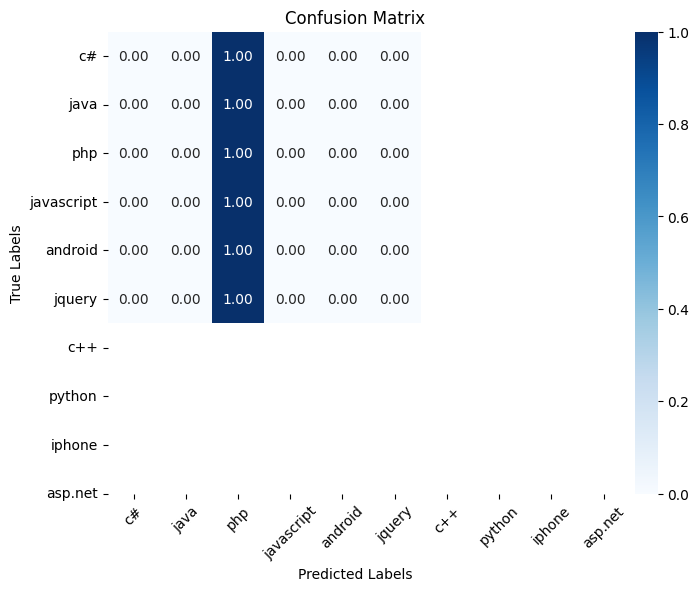

In [213]:
#  Generate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [207]:
# log the Confusion Matrix to Wandb
wandb.log({"conf_mat": wandb.plot.confusion_matrix(
    preds=val_predictions, y_true=val_labels,
    class_names=class_names)})


In [208]:
wandb.finish()


eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁███
train/global_step,▁▁████
train/learning_rate,█▁
train/loss,▁█
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


### <font color = 'pickle'> **Check the best saved model**</font>


In [ ]:
# After training, let us check the best checkpoint
# We need this for Predioctions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 2.
